In [129]:
# import
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random
import seaborn as sns
import imageio
import os 
import scipy.stats as stats 


In [130]:
#Parameters

plots_folder = "/Users/alexandranava/Desktop/EmbryonicCells/Plots/"

#Parameters
env_r = 5
Tsim = 120 #number of minutes to run simulation
dt = 2 # minutes between each simulation step 
N = int(Tsim/dt) # Number of iterations to run 
noise_std = 0.01
print(f"running {N} simulations...")
k = 7.5
theta = 1.2

#num of each species to start with
A_cells = 1
B_cells = 1
C_cells = 0

#attraction/repsulsion rates
a_a, a_b, a_c = [0, 0, 0]
b_a, b_b, b_c = [.1, 0, 0]
c_a, c_b, c_c = [0,0,0]

#radius for each species
A_radius = .2
B_radius = .2
C_radius = .5
# a_a, a_b, a_c = [.02, -.02, 0]
# b_a, b_b, b_c = [.005, 0, 0]
# c_a, c_b, c_c = [0, 0, -.2]

running 60 simulations...


In [131]:
def is_in_boundary(cell_position: list[int], r_env = 5):
  '''
  Parameters: 
  r: radius of defined region for cells
  cell_position: list for a single cell with x and y position
  Return: 
  true: within region
  false: exited region
  '''
  x = cell_position[0]
  y = cell_position[1]

  if np.sqrt(x**2 + y**2) < r_env:
    return True
  else: 
    return False


def calculate_cartesian_coords(theta, r):
  cos = np.cos(theta)
  sin = np.sin(theta)
  x = cos*r
  y = sin*r
  return [x, y]

def calculate_polar_coords(x, y):
  r = np.sqrt(x**2 + y**2)
  theta = np.arctan2(y, x)
  return [theta, r]

In [132]:
df_parameters = pd.DataFrame({
  "to": ["A", "B", "C", "radius"],
  "A": [a_a, a_b, a_c, A_radius], #top
  "B": [b_a, b_b, b_c, B_radius], # middle
  "C": [c_a, c_b, c_c, C_radius] #outer edge
}).set_index("to")

print(df_parameters)

          A    B    C
to                   
A       0.0  0.1  0.0
B       0.0  0.0  0.0
C       0.0  0.0  0.0
radius  0.2  0.2  0.5


In [133]:
#randomize initial cell positions
cell_theta_init = [random.uniform(0, 360) for _ in range(A_cells + B_cells + C_cells)]
cell_dist_init = [random.uniform(0, env_r) for _ in range(A_cells + B_cells + C_cells)]

coordinates = [calculate_cartesian_coords(theta, dist) for theta, dist in zip(cell_theta_init, cell_dist_init)]
xs_init, ys_init = zip(*coordinates)

#create dataframe
df = pd.DataFrame({
  "cell_numbers":  list(range(0, A_cells)) + list(range(0, B_cells)) + list(range(0, C_cells)),
  "species": ["A" for tmp in range(0, A_cells)] + ["B" for tmp in range(0, B_cells)] + ["C" for tmp in range(0, C_cells)],
  "timestep": [0 for tmp in range(0, A_cells + B_cells + C_cells)],
  "x":  xs_init,
  "y": ys_init
  #"radius": [A_radius for tmp in range(0, A_cells)] + [B_radius for tmp in range(0, B_cells)] + [C_radius for tmp in range(0, C_cells)]
  })


In [ ]:
def sp_attracting(cell1_data, cell2_data, attraction_coef: int):
  '''behavior of cells attracting/repelling
    returns x,y position of next position for cell1, ignoring boundary 
  '''

  x_main = cell1_data["x"]
  y_main = cell1_data["y"]

  x_to  = cell2_data["x"]
  y_to = cell2_data["y"]


  #distance used for normalization
  distance = np.sqrt((x_to - x_main)**2 + (y_to - y_main)**2)
  if distance == 0.0:
    distance = 1e-5

  x_direction_sp1 = (x_to - x_main) / distance
  y_direction_sp1 = (y_to - y_main) / distance
  attraction_coef = attraction_coef / distance  

  #new coordinates 
  x_sp1_next = x_main + attraction_coef * x_direction_sp1 + np.random.normal(0, noise_std) - x_main
  y_sp1_next = y_main + attraction_coef * y_direction_sp1 + np.random.normal(0, noise_std) - y_main

  return [x_sp1_next, y_sp1_next]

In [135]:
for i in range(0, N):
  df_t = df[df["timestep"] == i] # grab current timesteps from df

  #find resulting vector after attraction repulsion of every other cell
  for row_index, cell in df_t.iterrows(): 
    cell_sp = cell["species"] # main cell sp 
    attraction_vectors = [] # all pulling vectors
    
    #iterate through other cells
    df_other_cells_t = df_t[df_t.index != row_index] 
    for _, cell2_t in df_other_cells_t.iterrows(): 
  
      cell2_sp = cell2_t["species"] # second cell sp

      attraction_rate = df_parameters.loc[cell2_sp, cell_sp]
      displacement = sp_attracting(cell, cell2_t, attraction_rate) # result of a single cell pulling it  
      attraction_vectors.append(displacement)

    # new position for main cell
    new_x = sum(vector[0] for vector in attraction_vectors) + cell["x"]+ np.random.normal(0, noise_std) # total displacement plus original x
    new_y = sum(vector[1] for vector in attraction_vectors) + cell["y"]+ np.random.normal(0, noise_std) # total displacement plus original y

    #if leaves boundary, shorten magnitude to environment radius
    if not is_in_boundary([new_x, new_y]):
      theta, r = calculate_polar_coords(new_x, new_y)
      inboundary_coords = calculate_cartesian_coords(theta, env_r)
      new_x, new_y = inboundary_coords[0], inboundary_coords[1]

    # add new row to data
    df.loc[len(df)] = {
      "cell_numbers": cell["cell_numbers"],
      "species": cell_sp,
      "timestep": i+1,
      "x": new_x,
      "y": new_y
    }



  #go through each updated position and check if in radius of other cell
  # df_next_timestep = df[df["timestep"] == i + 1]
  # print(df_next_timestep)
  # for row_index, cell_tnext in df_next_timestep.iterrows():
  #     print("comparing distances")
  #     #main cell data
  #     cell_number = cell_tnext["cell_numbers"]
  #     cell_sp = cell_tnext["species"]
  #     cell_radius = df_parameters.loc["radius", cell_sp]
  #     cell_x = cell_tnext["x"]
  #     cell_y = cell_tnext["y"]
  #     cell_rdist = calculate_polar_coords(cell_x, cell_y)[1] #distance from origin

  #     #compare with other cells
  #     df_next_timestep_othercells = df_next_timestep[df_next_timestep.index != row_index]
  #     print(df_next_timestep_othercells)
  #     for _, other_cell in df_next_timestep_othercells.iterrows():
  #             print("hit")
  #             #data of other cell
  #             other_cell_num = other_cell["cell_numbers"]
  #             other_cell_sp = other_cell["species"]
  #             print(other_cell_sp)
  #             other_cell_radius = df_parameters.loc["radius", other_cell_sp]
  #             other_cell_x = other_cell["x"]
  #             other_cell_y = other_cell["y"]
  #             other_cell_rdist = calculate_polar_coords(other_cell_x, other_cell_y)[1] #distance from origin

  #             #tolerance and actual distance between eachother 
  #             combined_radius = cell_radius + other_cell_radius 
  #             print(combined_radius)
  #             distance = np.sqrt((other_cell_x - cell_x)**2 + (other_cell_y - cell_y)**2) #distance between center of each cell
  #             print(distance)
  #             print("-----")
  #            

/var/folders/hf/27j9pt1n18901_qs25pdn5cc0000gn/T/ipykernel_4756/909065815.py:69: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(frame)


GIF saved as /Users/alexandranava/Desktop/EmbryonicCells/Plots/simulation.gif


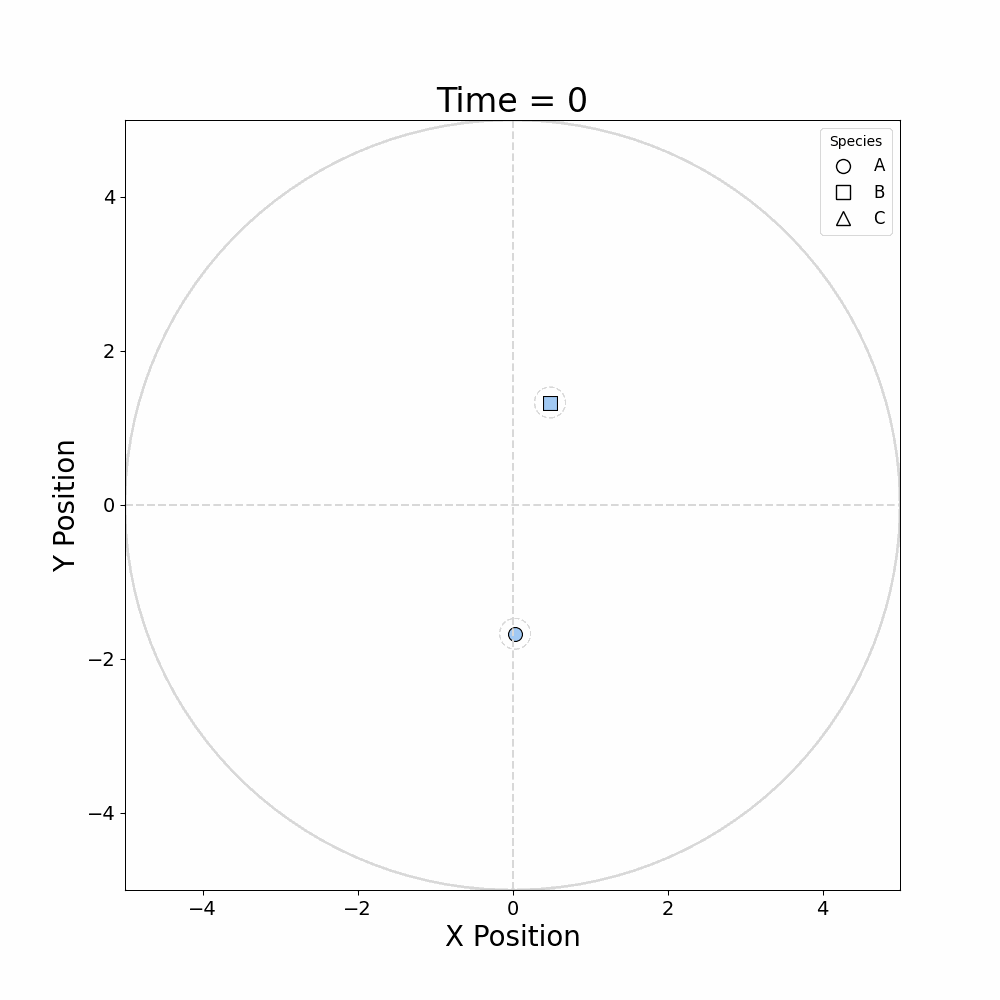

     cell_numbers species  timestep         x         y
0               0       A         0  0.034070 -1.672004
1               0       B         0  0.483844  1.330940
2               0       A         1  0.021327 -1.668312
3               0       B         1  0.484456  1.308341
4               0       A         2 -0.004816 -1.672132
..            ...     ...       ...       ...       ...
117             0       B        58 -2.390655 -4.386601
118             0       A        59  0.042149 -1.628289
119             0       B        59 -2.384489 -4.374846
120             0       A        60  0.035298 -1.621411
121             0       B        60 -2.390174 -4.370080

[122 rows x 5 columns]


In [136]:
import matplotlib.lines as mlines
from IPython.display import Image, display

def embryos_gif():
    frames = []
    markers = {'A': 'o', 'B': 's', 'C': '^'}  # Customize markers for each species

    for t in range(N+1):
        plt.figure(figsize=(10, 10))

        # DATA at TIMESTEP t
        timestep_data = df[df["timestep"] == t]
        sp_groups = timestep_data.groupby("species")
        for species, group in sp_groups:
            sns.scatterplot(
                x="x", 
                y="y", 
                data=group, 
                hue="cell_numbers", 
                marker=markers.get(species, 'o'),  
                palette="pastel", 
                s=100, 
                edgecolor="black", 
                legend=None
            )

        # BOUNDARIES FOR EACH CELL
        for _,cell_row in timestep_data.iterrows():
            x, y = cell_row["x"], cell_row["y"]
            radius = df_parameters.loc["radius", cell_row["species"]]
            cell_boundary = plt.Circle((x, y), radius, edgecolor="lightgrey", linestyle="--", facecolor="none", zorder=2)
            plt.gca().add_patch(cell_boundary)

        # ENVIRONMENT BOUNDARY
        env_boundary = plt.Circle((0, 0), env_r, edgecolor='lightgrey', facecolor='none', linewidth=2, label="experiment boundary", alpha = 0.8)
        plt.gca().add_patch(env_boundary)

        # LABELING
        t_min = t * dt 
        plt.title(rf"Time = {t_min}", fontsize=24)
        plt.axvline(0, linestyle="--", color="lightgrey")
        plt.axhline(0, linestyle="--", color="lightgrey")
        plt.xlim(-env_r, env_r)
        plt.ylim(-env_r, env_r)
        plt.xticks(fontsize=14)
        plt.yticks(fontsize=14)
        plt.xlabel("X Position", fontsize=20)
        plt.ylabel("Y Position", fontsize=20)
        plt.legend(loc="upper right", fontsize=14)

        # MARKERS
        legend_elements = [
                    mlines.Line2D([0], [0], marker=marker, markeredgecolor="black", markerfacecolor = "none", 
                                label=species, markersize=10, linestyle="None") 
                    for i, (species, marker) in enumerate(markers.items())
                ]
        plt.legend(handles=legend_elements, title="Species", loc="upper right", fontsize=12)

        # SAVE ith FRAME
        filename = f"frame_{t}.png"
        plt.savefig(filename)
        plt.close()
        frames.append(filename)

    # CREATE GIF
    gif_path = os.path.join(plots_folder, 'simulation.gif')
    with imageio.get_writer(gif_path, mode='I', duration=10) as writer:
        for frame in frames:
            image = imageio.imread(frame)
            writer.append_data(image)

    # CLEAN FRAMES
    for frame in frames:
        os.remove(frame)

    print(f"GIF saved as {gif_path}")
    return gif_path  # Return the path to the GIF

#display gif 
gif_path = embryos_gif()
display(Image(filename=gif_path))

print(df)